In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [25]:
#load data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Variational Autoencoders

In [34]:


def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(20, activation='relu')(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*64, activation='relu')(decoder_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean



In [35]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
latent_dim = 10
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss="binary_crossentropy",metrics=[rounded_accuracy])
vae.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_valid, X_valid))


Epoch 1/100
 28/860 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6288 - rounded_accuracy: 0.6732

W0000 00:00:1711513501.738132     684 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5834 - rounded_accuracy: 0.6875

W0000 00:00:1711513507.660557     683 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.5833 - rounded_accuracy: 0.6875 - val_loss: 0.5290 - val_rounded_accuracy: 0.7190
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4990 - rounded_accuracy: 0.7245 - val_loss: 0.5041 - val_rounded_accuracy: 0.7320
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4937 - rounded_accuracy: 0.7297 - val_loss: 0.5015 - val_rounded_accuracy: 0.7325
Epoch 4/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4925 - rounded_accuracy: 0.7315 - val_loss: 0.5015 - val_rounded_accuracy: 0.7331
Epoch 5/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4920 - rounded_accuracy: 0.7314 - val_loss: 0.4976 - val_rounded_accuracy: 0.7352
Epoch 6/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4912 - rounded_accuracy: 0.7328 - val_loss: 0.4999 - val_rounded_accuracy: 0.7361
Epoch 7/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4911 - rounded_accuracy: 0.7334 - val_loss: 0.4960 - val_rounded_accuracy: 0.73

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


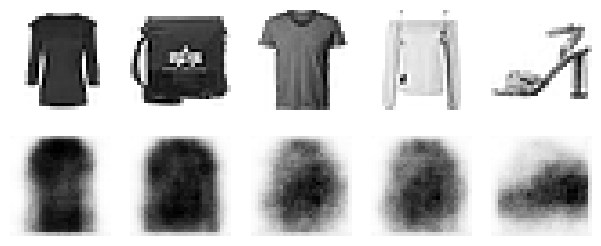

In [13]:
show_reconstructions(vae)
plt.show()

(12, 30)


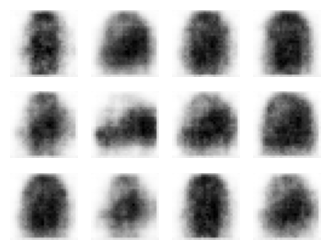

In [14]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, latent_dim])
images = decoder(codings).numpy()
plot_multiple_images(images, 4)
print(codings.shape)

# GANs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[codings_size]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # despues de compilar discriminator se entrena si se llama su .fit o su train_on_batch, no se  entrena en metodos de gan
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for i_,X_batch in enumerate(dataset):
            print(f'\r{i_+1}/{round(X_train.shape[0]/X_batch.shape[0])}',end='')
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep GAN

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[codings_size]),
    keras.layers.Dense(7 * 7 * 128),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)